# IMDB movie review sentiment classification with RNNs (aclImdb version)

In this notebook, we'll train a recurrent neural network (RNN) for sentiment classification using **Tensorflow** (version $\ge$ 2.0 required) with the **Keras API**. This notebook is largely based on the [Understanding recurrent neural networks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb) by François Chollet.

First, the needed imports.

In [1]:
%matplotlib inline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequencev
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import plot_model

from packaging.version import Version as V

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Tensorflow version: {}, and Keras version: {}.'.format(tf.__version__, tf.keras.__version__))
assert(V(tf.__version__) >= V("2.0.0"))

Using Tensorflow version: 2.12.0, and Keras version: 2.12.0.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.python.client import device_lib
    for d in device_lib.list_local_devices():
        if d.device_type == 'GPU':
            print('GPU', d.physical_device_desc)
else:
    print('No GPU, using CPU instead.')

GPU device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:08.0, compute capability: 6.0


## IMDB data set

Next we'll load the IMDB data set. First time we may have to download the data, which can take a while.

The dataset contains 50000 movies reviews from the Internet Movie Database, split into 25000 reviews for training and 25000 reviews for testing. Half of the reviews are positive (1) and half are negative (0).

The dataset has already been preprocessed, and each word has been replaced by an integer index.
The reviews are thus represented as varying-length sequences of integers.
(Word indices begin at "3", as "1" is used to mark the start of a review and "2" represents all out-of-vocabulary words. "0" will be used later to pad shorter reviews to a fixed size.)

In [3]:
DATADIR = "/media/gpu-data/imdb"
BATCH_SIZE = 16
validation_split=0.2
seed = 42

In [4]:
imdb_train = tf.keras.utils.text_dataset_from_directory(
    DATADIR+"/aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=validation_split,
    subset='training',
    seed=seed
)
imdb_valid = tf.keras.utils.text_dataset_from_directory(
    DATADIR+"/aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=validation_split,
    subset='validation',
    seed=seed
)
imdb_test = tf.keras.utils.text_dataset_from_directory(
    DATADIR+"/aclImdb/test",
    batch_size=BATCH_SIZE,
)

# Inspect first review
# Format is (review text tensor, label tensor)
print(imdb_train.unbatch().take(1).get_single_element())

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
(<tf.Tensor: shape=(), dtype=string, numpy=b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'>, <tf.Ten

## RNN model

### Initialization

Let's create an RNN model that contains an LSTM layer. The first layer in the network is an *Embedding* layer that converts integer indices to dense vectors of length `embedding_dims`. The output layer contains a single neuron and *sigmoid* non-linearity to match the binary groundtruth (`y_train`). 

Finally, we `compile()` the model, using *binary crossentropy* as the loss function and [*RMSprop*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [5]:
nb_words = 10000
maxlen = 80

vectorization_layer = layers.TextVectorization(max_tokens=nb_words,
                             output_mode='int',
                             output_sequence_length=maxlen)
train_text = imdb_train.map(lambda text, labels: text)
vectorization_layer.adapt(train_text)


In [6]:
# model parameters:
embedding_dims = 50
lstm_units = 32

inputs = keras.Input(shape=(1,), dtype=tf.string)

x = vectorization_layer(inputs)
x = layers.Embedding(input_dim=nb_words, 
                     output_dim=embedding_dims)(x)
x = layers.Dropout(0.2)(x)

x = layers.LSTM(lstm_units)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="rnn_model")

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Model: "rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 80)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 80, 50)            500000    
                                                                 
 dropout (Dropout)           (None, 80, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                         

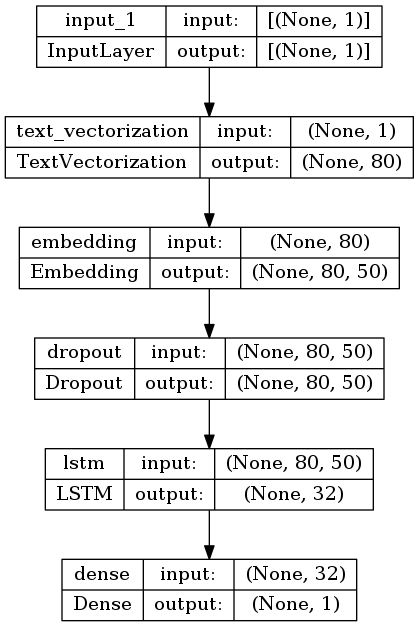

In [7]:
plot_model(model, show_shapes=True)

### Learning

Now we are ready to train our model.  An *epoch* means one pass through the whole training data. Note also that we are using a fraction of the training data as our validation set.

Note that LSTMs are rather slow to train.

In [8]:
%%time
epochs = 5

history = model.fit(imdb_train, validation_data=imdb_valid, epochs=epochs)

Epoch 1/5


Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.1/targets/x86_64-linux/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


1250/1250 [==============================] - 68s 50ms/step - loss: 0.5376 - accuracy: 0.7170 - val_loss: 0.4948 - val_accuracy: 0.7848
Epoch 2/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3975 - accuracy: 0.8298 - val_loss: 0.4324 - val_accuracy: 0.8098
Epoch 3/5
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3548 - accuracy: 0.8515 - val_loss: 0.4189 - val_accuracy: 0.8110
Epoch 4/5
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3272 - accuracy: 0.8644 - val_loss: 0.4220 - val_accuracy: 0.8136
Epoch 5/5
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3068 - accuracy: 0.8770 - val_loss: 0.4645 - val_accuracy: 0.8138
CPU times: user 2min 41s, sys: 33.7 s, total: 3min 15s
Wall time: 2min 25s


Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

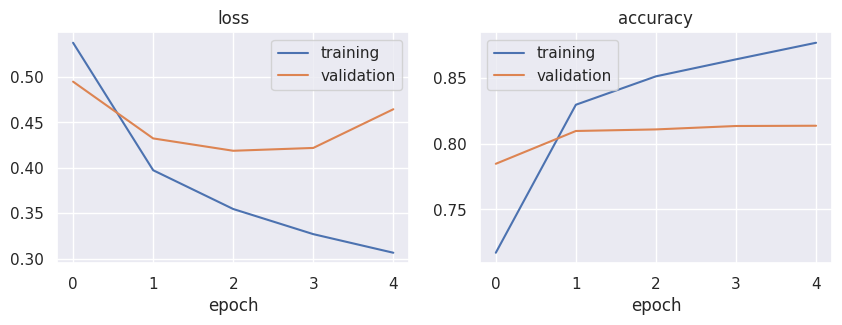

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.plot(history.epoch,history.history['loss'], label='training')
ax1.plot(history.epoch,history.history['val_loss'], label='validation')
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='best')

ax2.plot(history.epoch,history.history['accuracy'], label='training')
ax2.plot(history.epoch,history.history['val_accuracy'], label='validation')
ax2.set_title('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='best');

### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [10]:
scores = model.evaluate(imdb_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1563/1563 - 11s - loss: 0.4973 - accuracy: 0.7936 - 11s/epoch - 7ms/step
accuracy: 79.36%


We can also use the learned model to predict sentiments for new reviews:

In [11]:
myreview = 'This movie was the worst I have ever seen and the actors were horrible.'
#myreview = 'This movie is great and I madly love the plot from beginning to end.'

p = model.predict([myreview], batch_size=1)
print('Predicted sentiment: {}TIVE ({:.4f})'.format("POSI" if p[0,0]>0.5 else "NEGA", p[0,0]))

1/1 [==============================] - 1s 645ms/step
Predicted sentiment: NEGATIVE (0.0168)


## KerasNLP

In [12]:
import keras_nlp
#keras.mixed_precision.set_global_policy("mixed_float16")

In [13]:
bertmodel = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased_sst2")

In [14]:
scores = bertmodel.evaluate(imdb_test, verbose=2)
for i, m in enumerate(bertmodel.metrics_names):
    print("%s: %.4f" % (m, scores[i]))

1563/1563 - 15s - loss: 0.4629 - sparse_categorical_accuracy: 0.7835 - 15s/epoch - 9ms/step
loss: 0.4629
sparse_categorical_accuracy: 0.7835


In [33]:
myreview = 'This movie was the worst I have ever seen and the actors were horrible.'
#myreview = 'This movie is great and I madly love the plot from beginning to end.'

logits = bertmodel.predict([myreview], batch_size=1)
probs = tf.nn.softmax(logits).numpy().squeeze()
print('Predicted sentiment: {}TIVE ({:.4f}/{:.4f})'.format("POSI" if probs[1]>probs[0] else "NEGA", probs[0], probs[1]))

1/1 [==============================] - 1s 995ms/step
Predicted sentiment: NEGATIVE (0.9938/0.0062)


In [ ]:
bertmodel2 = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=2,
)

In [ ]:
%%time 

bertmodel2.fit(
    imdb_train,
    validation_data=imdb_valid,
    epochs=1,
)

In [ ]:
scores2 = bertmodel2.evaluate(imdb_test, verbose=2)
for i, m in enumerate(bertmodel2.metrics_names):
    print("%s: %.4f" % (m, scores2[i]))

In [33]:
myreview = 'This movie was the worst I have ever seen and the actors were horrible.'
#myreview = 'This movie is great and I madly love the plot from beginning to end.'

logits = bertmodel2.predict([myreview], batch_size=1)
probs = tf.nn.softmax(logits).numpy().squeeze()
print('Predicted sentiment: {}TIVE ({:.4f}/{:.4f})'.format("POSI" if probs[1]>probs[0] else "NEGA", probs[0], probs[1]))

1/1 [==============================] - 1s 995ms/step
Predicted sentiment: NEGATIVE (0.9938/0.0062)


## Task 1: Two LSTM layers

Create a model with two LSTM layers. Optionally, you can also use [Bidirectional layers](https://keras.io/api/layers/recurrent_layers/bidirectional/).

The code below is missing the model definition. You can copy any suitable layers from the example above.

In [ ]:
ex1_inputs = keras.Input(shape=(None,), dtype="int64")

# WRITE YOUR CODE HERE

ex1_outputs = None

Example answer:

In [ ]:
%load tf2-imdb-rnn-example-answer.py

In [ ]:
assert ex1_outputs is not None, "You need to write the missing model definition"

ex1_model = keras.Model(inputs=ex1_inputs, outputs=ex1_outputs,
                    name="rnn_model_with_two_lstm_layers")

ex1_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
print(ex1_model.summary())

In [ ]:
%%time
ex1_epochs = 5
ex1_validation_split = 0.2

ex1_history = ex1_model.fit(x_train, y_train, batch_size=128,
          epochs=ex1_epochs, 
          validation_split=ex1_validation_split)

Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.plot(ex1_history.epoch,ex1_history.history['loss'], label='training')
ax1.plot(ex1_history.epoch,ex1_history.history['val_loss'], label='validation')
ax1.set_title('Task 1: loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='best')

ax2.plot(ex1_history.epoch,ex1_history.history['accuracy'], label='training')
ax2.plot(ex1_history.epoch,ex1_history.history['val_accuracy'], label='validation')
ax2.set_title('Task 1: accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='best');

In [ ]:
ex1_scores = ex1_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (ex1_model.metrics_names[1], ex1_scores[1]*100))

## Task 2: Model tuning

Modify the model further.  Try to improve the classification accuracy on the test set, or experiment with the effects of different parameters.

To combat overfitting, you can try for example to add dropout. For [LSTMs](https://keras.io/api/layers/recurrent_layers/lstm/), dropout for inputs and the recurrent states can be set with the `dropout` and `recurrent_dropout` arguments:

    x = layers.LSTM(lstm_units, dropout=0.2,
                    recurrent_dropout=0.3)(x)

Another option is to use early stopping in training. It can be implemented with the [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) callback, for example:

    callbacks = [keras.callbacks.EarlyStopping(
                 monitor="val_loss", patience=1,
                 restore_best_weights=True)]

The callback then needs to be added as an argument to the [`model.fit()`](https://keras.io/api/models/model_training_apis/#fit-method) method.

You can also consult the Keras documentation at https://keras.io/. 

---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/04-tf2-imdb-rnn.ipynb).*